In [1]:
# Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import linregress
from datetime import datetime
from geopy.distance import geodesic
import pymongo
from pymongo import MongoClient
import os

In [2]:
# Setup MongoDB Connection
serverUrl = os.environ.get('MONGO', "mongodb://localhost:27017")
client = pymongo.MongoClient(serverUrl)

In [3]:
# Connect to MongoDB (nuforc) and collections (airforce_bases) & (usa_sightings)
db = client.nuforc
airforce_bases_collection = db.airforce_bases
usa_sightings_collection = db.usa_sightings

In [4]:
# Fetch data from MongoDB
air_force_bases = list(airforce_bases_collection.find())
ufo_sightings = list(usa_sightings_collection.find())

In [6]:
# Convert MongoDB data to pandas DataFrame
ufo_sightings_df = pd.DataFrame(ufo_sightings)
ufo_sightings_df

,_id,Unnamed: 0,SIGHTING_ID,OCCURRED_DATE,CITY,STATE,COUNTRY,SHAPE,SUMMARY,YEAR,CITYSTATE,Lat,Lng
0,668c9daed9aab7f5eea72259,0,1,2024-06-20,Cranston,RI,USA,Flash,My wife and I as well as our 2 children witnes...,2024,"Cranston, RI",41.78,-71.44
1,668c9daed9aab7f5eea7225a,14,2,2024-06-20,Key West,FL,USA,Light,Saw unexplainable lights slightly west of Nort...,2024,"Key West, FL",24.56,-81.77
2,668c9daed9aab7f5eea7225b,45737,3,2024-06-20,Oklahoma City,OK,USA,Light,Erratically moving light at high altitude,2024,"Oklahoma City, OK",35.47,-97.52
3,668c9daed9aab7f5eea7225c,95,5,2024-06-19,Jacksonville,FL,USA,Triangle,Black triangle very low no noise,2024,"Jacksonville, FL",30.33,-81.66
4,668c9daed9aab7f5eea7225d,56720,9,2024-06-18,Lee's Summit,MO,USA,Oval,"Two Lights in Lee's Summit, MO SW Sky, One Dis...",2024,"Lee's Summit, MO",38.91,-94.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46923,668c9daed9aab7f5eea7d9a4,795,50218,2014-02-18,Richmond,IN,USA,Fireball,Red fireball object seen over east central Ind...,2014,"Richmond, IN",37.94,-122.35
46924,668c9daed9aab7f5eea7d9a5,58246,50225,2014-02-18,Mardela Springs,MD,USA,Light,One star-like light turned sharp and sped up t...,2014,"Mardela Springs, MD",38.46,-75.76
46925,668c9daed9aab7f5eea7d9a6,37817,50224,2014-02-18,Wentzville,MO,USA,Triangle,"Dark gray boomerang craft, no lights, gliding ...",2014,"Wentzville, MO",38.82,-90.87
46926,668c9daed9aab7f5eea7d9a7,9311,50219,2014-02-18,Houston,TX,USA,Disk,Silver disc on the right of me and then golden...,2014,"Houston, TX",29.76,-95.37


In [7]:
# Function to calculate distance to nearest Air Force base
def distance_to_nearest_base(lat, lon):
    distances = [geodesic((lat, lon), (base['latitude'], base['longitude'])).miles for base in air_force_bases]
    return min(distances)

In [8]:
# Calculate distances
ufo_sightings_df['distance_to_base'] = ufo_sightings_df.apply(
    lambda row: distance_to_nearest_base(row['Lat'], row['Lng']), axis=1)

# ufo_sightings_df

In [9]:
# Save the updated DataFrame to a CSV file
ufo_sightings_df.to_csv('../Output/ufo_sightings_distance_to_base.csv', index=False)

In [10]:
# First, convert the date string to a datetime object
ufo_sightings_df['OCCURRED_DATE'] = pd.to_datetime(ufo_sightings_df['OCCURRED_DATE'])

In [11]:
# Then, convert the datetime object to a Unix timestamp (in seconds)
ufo_sightings_df['timestamp'] = ufo_sightings_df['OCCURRED_DATE'].astype(int) / 10**9

In [12]:
# Extract timestamps (x) and distances to base (y) for regression analysis
x = ufo_sightings_df['timestamp'].values
y = ufo_sightings_df['distance_to_base'].values

In [13]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [14]:
# Generate values for the regression line
regression_values = x * slope + intercept

The Pearson correlation coefficient (r-value) between date of UFO sighting and distance to nearest Air Force base is: -0.01
P-value: 5.36e-02


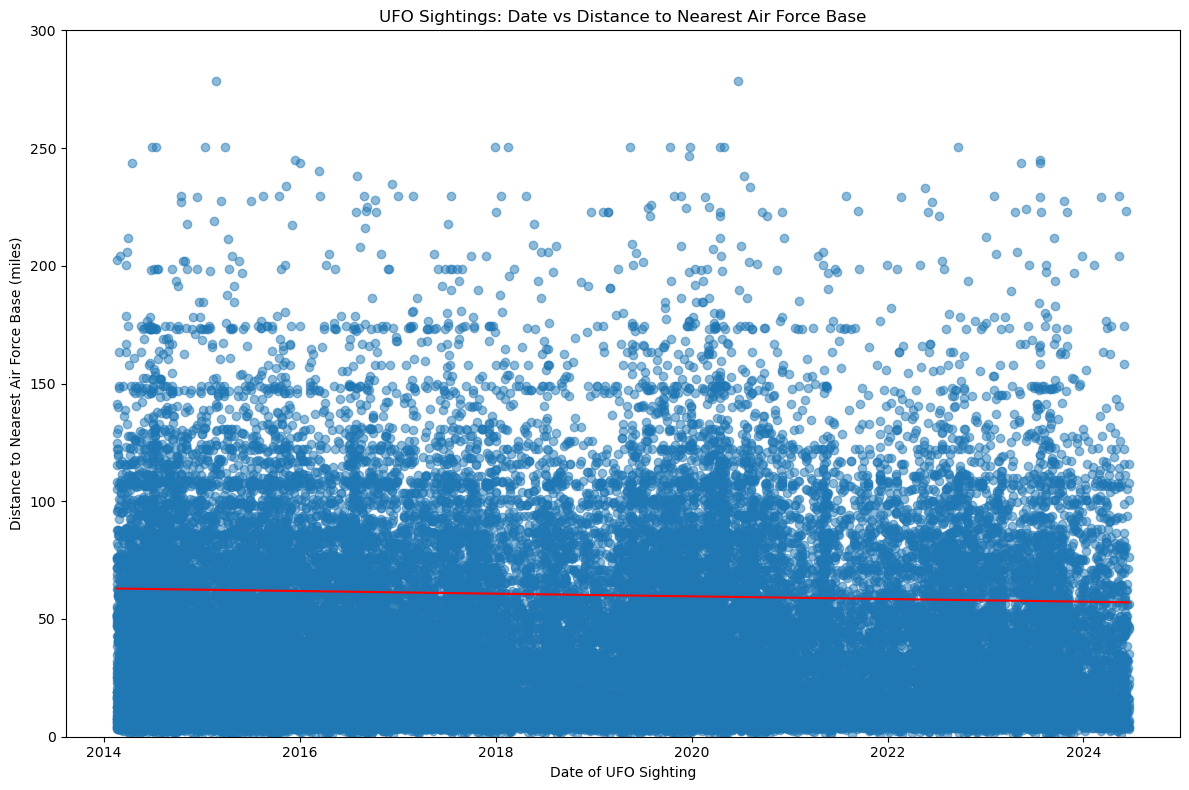

In [20]:
# Calculate the Pearson correlation coefficient
correlation, p_value_corr = st.pearsonr(x, y)
print(f'The Pearson correlation coefficient (r-value) between date of UFO sighting and distance to nearest Air Force base is: {r_value:.2f}')

# Print p-value
print(f"P-value: {p_value:.2e}")

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(ufo_sightings_df['OCCURRED_DATE'], y, alpha=0.5)
plt.xlabel('Date of UFO Sighting')
plt.ylabel('Distance to Nearest Air Force Base (miles)')
plt.title('UFO Sightings: Date vs Distance to Nearest Air Force Base')
# plt.xticks(rotation=45, ha='right')

# Set y-axis limits to 0-300 miles
plt.ylim(0, 300)

# Plot the regression line
plt.plot(ufo_sightings_df['OCCURRED_DATE'], regression_values, color="red",
         label=f'y={slope:.2f}x + {intercept:.2f}')

# Adjust the layout to prevent cutoff
plt.tight_layout()

# Save plot
plt.savefig('../Output/ufo_sightings_scatter_plot_2014_to_2024.png', bbox_inches='tight')
plt.show()

# Analysis of Correlation between UFO Sighting Dates and Proximity to Air Force Bases (2014 to Current Date)

## Results
The Pearson correlation coefficient (r-value) between date of UFO sighting and distance to nearest Air Force base is: -0.01

## Interpretation

### 1. Strength of Correlation
- A correlation of -0.01 is extremely close to zero.
- This indicates a very weak correlation between the two variables.

### 2. Direction of Correlation
- The negative sign (-0.01) suggests a slightly negative correlation.
- This means that as dates increase (move forward in time), there's a very slight tendency for the distances to decrease, but the effect is negligible.

### 3. Practical Significance
- With a correlation this close to zero, it's safe to say there's effectively no linear relationship between the date of UFO sightings and their distance to the nearest Air Force base.
- The timing of UFO sightings doesn't appear to be related to how close they are to Air Force bases, at least not in any linear way.

### 4. Statistical Significance
Based on the p-value of 0.0536, the results correspond to a confidence level of approximately 94.64%, suggesting that there is about 94.64% confidence that the observed relationship between UFO sighting dates and distances to the nearest Air Force base is not due to random chance. This confidence level falls slightly below the commonly used 95% threshold for statistical significance, but above the 90% level, indicating that the results are "marginally significant" or "approaching significance."

In practical terms, if this study were to be repeated many times with different samples from the same population, about 94.64% of the time one would expect to find a relationship at least as strong as the one observed. While this level of confidence suggests some evidence of a relationship, it's not quite strong enough to be considered conclusive in statistical practice, as there's still about a 5.36% chance that the observed relationship could be due to random variation.

Given these findings, the results are suggestive but not definitive, warranting careful interpretation and possibly further investigation with larger sample sizes or different analytical approaches.

### 5. Interpretation for the Study
- This result suggests that UFO sightings are not getting systematically closer to or farther from Air Force bases over time.
- The timing of UFO sightings appears to be independent of their proximity to Air Force bases.

### 6. Limitations and Future Research Areas
- This only rules out a linear relationship. There could still be non-linear relationships that this analysis doesn't capture that could be explored:
  - Polynomial regression (quadratic, cubic, etc.)
  - Logarithmic relationships
  - Exponential relationships
  - Sinusoidal patterns (for cyclical trends)
- There might be other factors influencing the relationship that aren't accounted for in this simple correlation:
  - Geographic location (latitude, longitude)
  - Population density of the area
  - Proximity to other types of military installations
  - Time of day/night of sightings
  - Weather conditions
  - Major world events or media coverage of UFOs
  - Technological advancements in aviation or surveillance
  - Changes in reporting mechanisms over time
- Future research areas:
  - Multiple regression analysis
  - Time series analysis
  - Geospatial analysis
  - Machine learning techniques like Random Forests or Neural Networks to capture complex, non-linear relationships
  - Clustering analysis to identify patterns in the data

## Conclusion
Based on this correlation coefficient, there doesn't appear to be any meaningful linear relationship between the date of UFO sightings and their proximity to Air Force bases. This could be an interesting finding in itself, as it might contradict hypotheses about changing patterns of UFO sightings in relation to military installations over time.

In [17]:
# Calculate Pearson Correlation Coefficient (r-value) for the year 2020

start_date = pd.to_datetime('2020-01-01')  # Choose your start date
end_date = start_date + pd.DateOffset(months=12)

filtered_df = ufo_sightings_df[(ufo_sightings_df['OCCURRED_DATE'] >= start_date) & 
                               (ufo_sightings_df['OCCURRED_DATE'] < end_date)]

# Recalculate correlation with filtered data
x_filtered = filtered_df['timestamp'].values
y_filtered = filtered_df['distance_to_base'].values
correlation_filtered, _ = st.pearsonr(x_filtered, y_filtered)
print(f'The Pearson correlation coefficient (r-value) for the year 2020 is: {correlation_filtered:.2f}')

The Pearson correlation coefficient (r-value) for the year 2020 is: -0.02


# Analysis of UFO Sightings and Air Force Base Proximity for 2020

## Key Finding
The Pearson correlation coefficient (r-value) for 2020 is: -0.02

## Interpretation

1. **Strength of correlation:** An r-value of -0.02 indicates an extremely weak correlation between the date of UFO sightings and their distance to the nearest Air Force base in 2020.

2. **Direction of correlation:** The negative sign suggests a very slight inverse relationship, meaning that as the date progresses, there's a minimal tendency for the distance to decrease.

3. **Practical significance:** With a value this close to zero, there is effectively no linear relationship between the variables for the year 2020.

4. **Comparison to overall data:** This result (-0.02 for 2020) is similar to the overall correlation found earlier (-0.01), suggesting consistency in the lack of strong correlation across different time periods.

5. **Interpretation:** UFO sighting dates in 2020 do not appear to have any meaningful linear relationship with their proximity to Air Force bases.

## Conclusion
This result reinforces the earlier finding that there is no substantial linear relationship between when UFO sightings occur and how close they are to Air Force bases, at least for the year 2020. It's important to note that while this analysis rules out a linear relationship, it doesn't preclude the possibility of more complex, non-linear relationships between these variables.

In [18]:
# Calculate Pearson Correlation Coefficient (r-value) for 1st Quarter, 2020

start_date = pd.to_datetime('2020-01-01')  # Choose your start date
end_date = start_date + pd.DateOffset(months=3)

filtered_df = ufo_sightings_df[(ufo_sightings_df['OCCURRED_DATE'] >= start_date) & 
                               (ufo_sightings_df['OCCURRED_DATE'] < end_date)]

# Recalculate correlation with filtered data
x_filtered = filtered_df['timestamp'].values
y_filtered = filtered_df['distance_to_base'].values
correlation_filtered, _ = st.pearsonr(x_filtered, y_filtered)
print(f'The Pearson correlation coefficient (r-value) for 1st Quarter, 2020 is: {correlation_filtered:.2f}')

The Pearson correlation coefficient (r-value) for 1st Quarter, 2020 is: -0.04


In [19]:
client.close

<bound method MongoClient.close of MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)>